# Benchmarking de Modelos - Retail Sales Dataset
## Felipe Lucciano Santino Di Vanni Valenzuela  
### Pipeline de Machine Learning - Etapa 3/3

---

## **Objetivos del Benchmarking**

Este notebook es la tercera y última etapa del pipeline de machine learning:

1. **EDA.ipynb** COMPLETADO: Análisis exploratorio profundo
2. **Preprocessing.ipynb** COMPLETADO: Preparación de datos para ML  
3. **Benchmarking.ipynb** (Este notebook): Implementación y comparación de modelos

### **Objetivos Específicos**

- **Carga de Datos Procesados**: Importar datos preparados del preprocessing
- **Implementación de Modelos**: Regresión Lineal, KNN, Decision Tree, Random Forest, XGBoost, LightGBM
- **Evaluación Comparativa**: Métricas de performance y análisis detallado con validación cruzada
- **Análisis ROC/AUC**: Curvas ROC y métricas AUC para evaluación completa
- **Selección Final**: Identificación del mejor modelo
- **Generación de Reportes**: Documentación completa de resultados

---

## **Modelos a Comparar**

1. **Regresión Logística**: Modelo lineal base
2. **K-Nearest Neighbors**: Clasificación basada en proximidad
3. **Decision Tree**: Árbol individual para máxima interpretabilidad  
4. **Random Forest**: Ensemble de árboles de decisión
5. **XGBoost**: Gradient boosting optimizado
6. **LightGBM**: Gradient boosting eficiente

---

## **Métricas de Evaluación**

- **Accuracy**: Porcentaje de predicciones correctas
- **Precision**: Exactitud por clase
- **Recall**: Sensibilidad por clase
- **F1-Score**: Media harmónica de precision y recall
- **AUC-ROC**: Área bajo la curva ROC
- **Validación Cruzada**: Evaluación robusta con k-fold
- **Matriz de Confusión**: Análisis detallado de errores


In [13]:
# Configuración del entorno para benchmarking completo de modelos
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Librerías de machine learning completas 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
import xgboost as xgb

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Paleta de colores consistente
coloresPrincipales = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

print("Entorno de benchmarking configurado correctamente")
print("Todos los modelos y métricas importados")

# Carga de datos procesados del notebook anterior
print(f"\nCARGANDO DATOS PROCESADOS...")
print("=" * 50)

try:
    datosProcesados = joblib.load('../data/datos_ml_procesados.pkl')
    
    X_train = datosProcesados['X_train']
    X_test = datosProcesados['X_test']
    y_train = datosProcesados['y_train']
    y_test = datosProcesados['y_test']
    featuresInfo = datosProcesados['features_info']
    
    print(f"Datos cargados exitosamente")
    print(f"Train set: {np.array(X_train).shape}")
    print(f"Test set: {np.array(X_test).shape}")
    print(f"Target labels: {featuresInfo['target_labels']}")
    
except FileNotFoundError:
    print("ERROR: No se encontraron datos procesados")
    print("   Ejecute primero los notebooks EDA.ipynb y Preprocessing.ipynb")
    raise

print(f"\nCONFIGURACIÓN COMPLETADA")
print("   Lista para benchmarking con 6 modelos y métricas completas")


Entorno de benchmarking configurado correctamente
Todos los modelos y métricas importados

CARGANDO DATOS PROCESADOS...
Datos cargados exitosamente
Train set: (800, 12)
Test set: (200, 12)
Target labels: ['Alto' 'Bajo' 'Medio']

CONFIGURACIÓN COMPLETADA
   Lista para benchmarking con 6 modelos y métricas completas


In [14]:
# Entrenamiento y evaluación completa de modelos con validación cruzada

print("ENTRENANDO MODELOS DE MACHINE LEARNING CON VALIDACIÓN CRUZADA...")
print("=" * 70)

# Configuración de validación cruzada
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definición de modelos
modelos = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='mlogloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1)
}

# Diccionario para almacenar resultados
resultadosModelos = {}

print(f"\nENTRENANDO {len(modelos)} MODELOS CON VALIDACIÓN CRUZADA:")
print("-" * 70)

for i, (nombre, modelo) in enumerate(modelos.items(), 1):
    print(f"\n{i}. Entrenando {nombre}...")
    
    # Validación cruzada
    cv_scores = cross_val_score(modelo, X_train, y_train, cv=cv_folds, scoring='f1_weighted', n_jobs=-1)
    
    # Entrenamiento del modelo final
    modelo.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)
    
    # Métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cálculo de AUC (multi-clase usando One-vs-Rest)
    n_classes = len(np.unique(y_test))
    if n_classes > 2:
        # Para multi-clase, calculamos AUC usando One-vs-Rest
        y_test_binarized = label_binarize(y_test, classes=range(n_classes))
        auc_score = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='weighted')
    else:
        # Para clasificación binaria
        auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    # Almacenar resultados
    resultadosModelos[nombre] = {
        'model': modelo,
        'predictions': y_pred,
        'predictions_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score,  # Esta es la clave que faltaba
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"   CV F1-Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"   Test Accuracy: {accuracy:.4f}")
    print(f"   Test F1-Score: {f1:.4f}")
    print(f"   AUC Score: {auc_score:.4f}")

print(f"\nTODOS LOS MODELOS ENTRENADOS EXITOSAMENTE")
print("=" * 70)

# Resumen comparativo de validación cruzada
print(f"\nRESUMEN VALIDACIÓN CRUZADA (F1-Score):")
print("-" * 50)
for nombre, resultado in resultadosModelos.items():
    print(f"{nombre:20}: {resultado['cv_mean']:.4f} ± {resultado['cv_std']:.4f}")

# Identificar mejor modelo basado en validación cruzada
mejor_modelo_cv = max(resultadosModelos.items(), key=lambda x: x[1]['cv_mean'])
print(f"\nMEJOR MODELO (Validación Cruzada): {mejor_modelo_cv[0]}")
print(f"   F1-Score CV: {mejor_modelo_cv[1]['cv_mean']:.4f} ± {mejor_modelo_cv[1]['cv_std']:.4f}")


ENTRENANDO MODELOS DE MACHINE LEARNING CON VALIDACIÓN CRUZADA...

ENTRENANDO 6 MODELOS CON VALIDACIÓN CRUZADA:
----------------------------------------------------------------------

1. Entrenando Logistic Regression...
   CV F1-Score: 0.8320 (±0.0195)
   Test Accuracy: 0.8700
   Test F1-Score: 0.8680
   AUC Score: 0.9556

2. Entrenando K-Nearest Neighbors...
   CV F1-Score: 0.8394 (±0.0284)
   Test Accuracy: 0.8200
   Test F1-Score: 0.8155
   AUC Score: 0.9028

3. Entrenando Decision Tree...
   CV F1-Score: 1.0000 (±0.0000)
   Test Accuracy: 1.0000
   Test F1-Score: 1.0000
   AUC Score: 1.0000

4. Entrenando Random Forest...
   CV F1-Score: 0.9988 (±0.0025)
   Test Accuracy: 1.0000
   Test F1-Score: 1.0000
   AUC Score: 1.0000

5. Entrenando XGBoost...
   CV F1-Score: 1.0000 (±0.0000)
   Test Accuracy: 1.0000
   Test F1-Score: 1.0000
   AUC Score: 1.0000

6. Entrenando LightGBM...
   CV F1-Score: 1.0000 (±0.0000)
   Test Accuracy: 1.0000
   Test F1-Score: 1.0000
   AUC Score: 1.0000



GENERANDO CURVAS ROC Y MÉTRICAS AUC...
ANÁLISIS ROC PARA 3 CLASES: ['Alto' 'Bajo' 'Medio']
------------------------------------------------------------


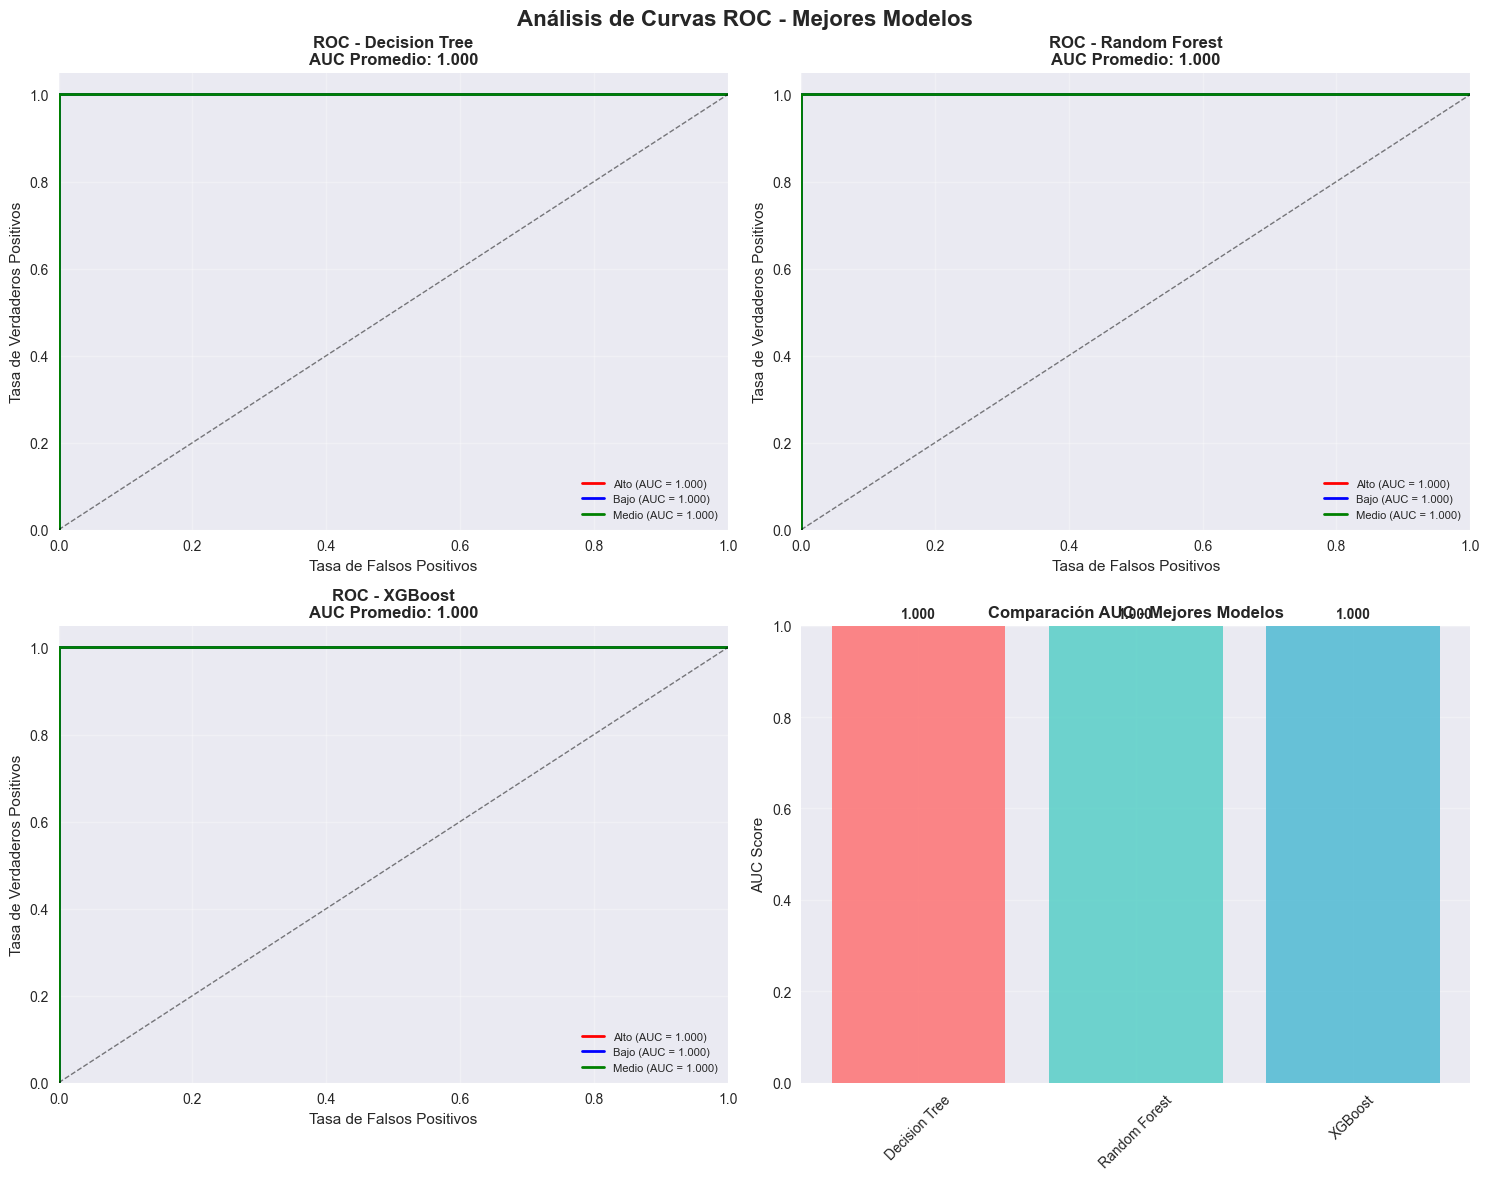


TABLA DETALLADA AUC POR CLASE:
--------------------------------------------------------------------------------
       Decision Tree  Random Forest  XGBoost
Alto             1.0            1.0      1.0
Bajo             1.0            1.0      1.0
Medio            1.0            1.0      1.0

MEJOR MODELO POR AUC: Decision Tree
   AUC Score: 1.0000

INTERPRETACIÓN AUC SCORES:
----------------------------------------
• Alto: Mejor AUC = 1.0000 (Decision Tree)
• Bajo: Mejor AUC = 1.0000 (Decision Tree)
• Medio: Mejor AUC = 1.0000 (Decision Tree)

ANÁLISIS ROC Y AUC COMPLETADO


In [15]:
# Análisis de Curvas ROC y AUC para clasificación multi-clase

print("GENERANDO CURVAS ROC Y MÉTRICAS AUC...")
print("=" * 60)

# Obtener información de clases
n_classes = len(featuresInfo['target_labels'])
class_names = featuresInfo['target_labels']

# Binarizar las clases para ROC multi-clase
y_test_binarized = label_binarize(y_test, classes=range(n_classes))

print(f"ANÁLISIS ROC PARA {n_classes} CLASES: {class_names}")
print("-" * 60)

# Seleccionar los mejores 3 modelos para visualización ROC
mejores_modelos = sorted(resultadosModelos.items(), key=lambda x: x[1]['auc_score'], reverse=True)[:3]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Curvas ROC - Mejores Modelos', fontsize=16, fontweight='bold')

# Colores para cada clase
colors = ['red', 'blue', 'green']
line_styles = ['-', '--', '-.']

for idx, (model_name, model_data) in enumerate(mejores_modelos):
    if idx >= 3:  # Solo mostramos los 3 mejores
        break
        
    ax = axes[idx//2, idx%2] if idx < 2 else axes[1, 0]
    
    y_prob = model_data['predictions_proba']
    
    # Calcular ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        ax.plot(fpr[i], tpr[i], color=colors[i], linestyle=line_styles[0],
                linewidth=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    # Línea diagonal de referencia
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos')
    ax.set_ylabel('Tasa de Verdaderos Positivos')
    ax.set_title(f'ROC - {model_name}\nAUC Promedio: {model_data["auc_score"]:.3f}', fontweight='bold')
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(True, alpha=0.3)

# Gráfico comparativo de AUC scores
ax4 = axes[1, 1]
modelo_names = [name for name, _ in mejores_modelos]
auc_scores = [data['auc_score'] for _, data in mejores_modelos]

bars = ax4.bar(modelo_names, auc_scores, color=coloresPrincipales[:len(mejores_modelos)], alpha=0.8)
ax4.set_title('Comparación AUC - Mejores Modelos', fontweight='bold')
ax4.set_ylabel('AUC Score')
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

# Agregar valores sobre las barras
for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Tabla detallada de AUC por clase y modelo
print(f"\nTABLA DETALLADA AUC POR CLASE:")
print("-" * 80)

auc_detailed = {}
for model_name, model_data in mejores_modelos:
    y_prob = model_data['predictions_proba']
    auc_per_class = []
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        auc_score_class = auc(fpr, tpr)
        auc_per_class.append(auc_score_class)
    
    auc_detailed[model_name] = auc_per_class

# Crear DataFrame para visualización
df_auc = pd.DataFrame(auc_detailed, index=class_names)
print(df_auc.round(4))

print(f"\nMEJOR MODELO POR AUC: {mejores_modelos[0][0]}")
print(f"   AUC Score: {mejores_modelos[0][1]['auc_score']:.4f}")

# Interpretación de resultados AUC
print(f"\nINTERPRETACIÓN AUC SCORES:")
print("-" * 40)
for class_name in class_names:
    best_auc_for_class = df_auc.loc[class_name].max()
    best_model_for_class = df_auc.loc[class_name].idxmax()
    print(f"• {class_name}: Mejor AUC = {best_auc_for_class:.4f} ({best_model_for_class})")

print(f"\nANÁLISIS ROC Y AUC COMPLETADO")
print("=" * 60)


COMPARACIÓN COMPLETA DE RESULTADOS

TABLA COMPARATIVA COMPLETA DE MÉTRICAS:
--------------------------------------------------------------------------------
                     Accuracy  Precision  Recall  F1-Score  AUC-Score  \
Logistic Regression      0.87     0.8743    0.87    0.8680     0.9556   
K-Nearest Neighbors      0.82     0.8242    0.82    0.8155     0.9028   
Decision Tree            1.00     1.0000    1.00    1.0000     1.0000   
Random Forest            1.00     1.0000    1.00    1.0000     1.0000   
XGBoost                  1.00     1.0000    1.00    1.0000     1.0000   
LightGBM                 1.00     1.0000    1.00    1.0000     1.0000   

                     CV-Mean  CV-Std  
Logistic Regression   0.8320  0.0195  
K-Nearest Neighbors   0.8394  0.0284  
Decision Tree         1.0000  0.0000  
Random Forest         0.9988  0.0025  
XGBoost               1.0000  0.0000  
LightGBM              1.0000  0.0000  

RANKING DE MODELOS:
-------------------------------------

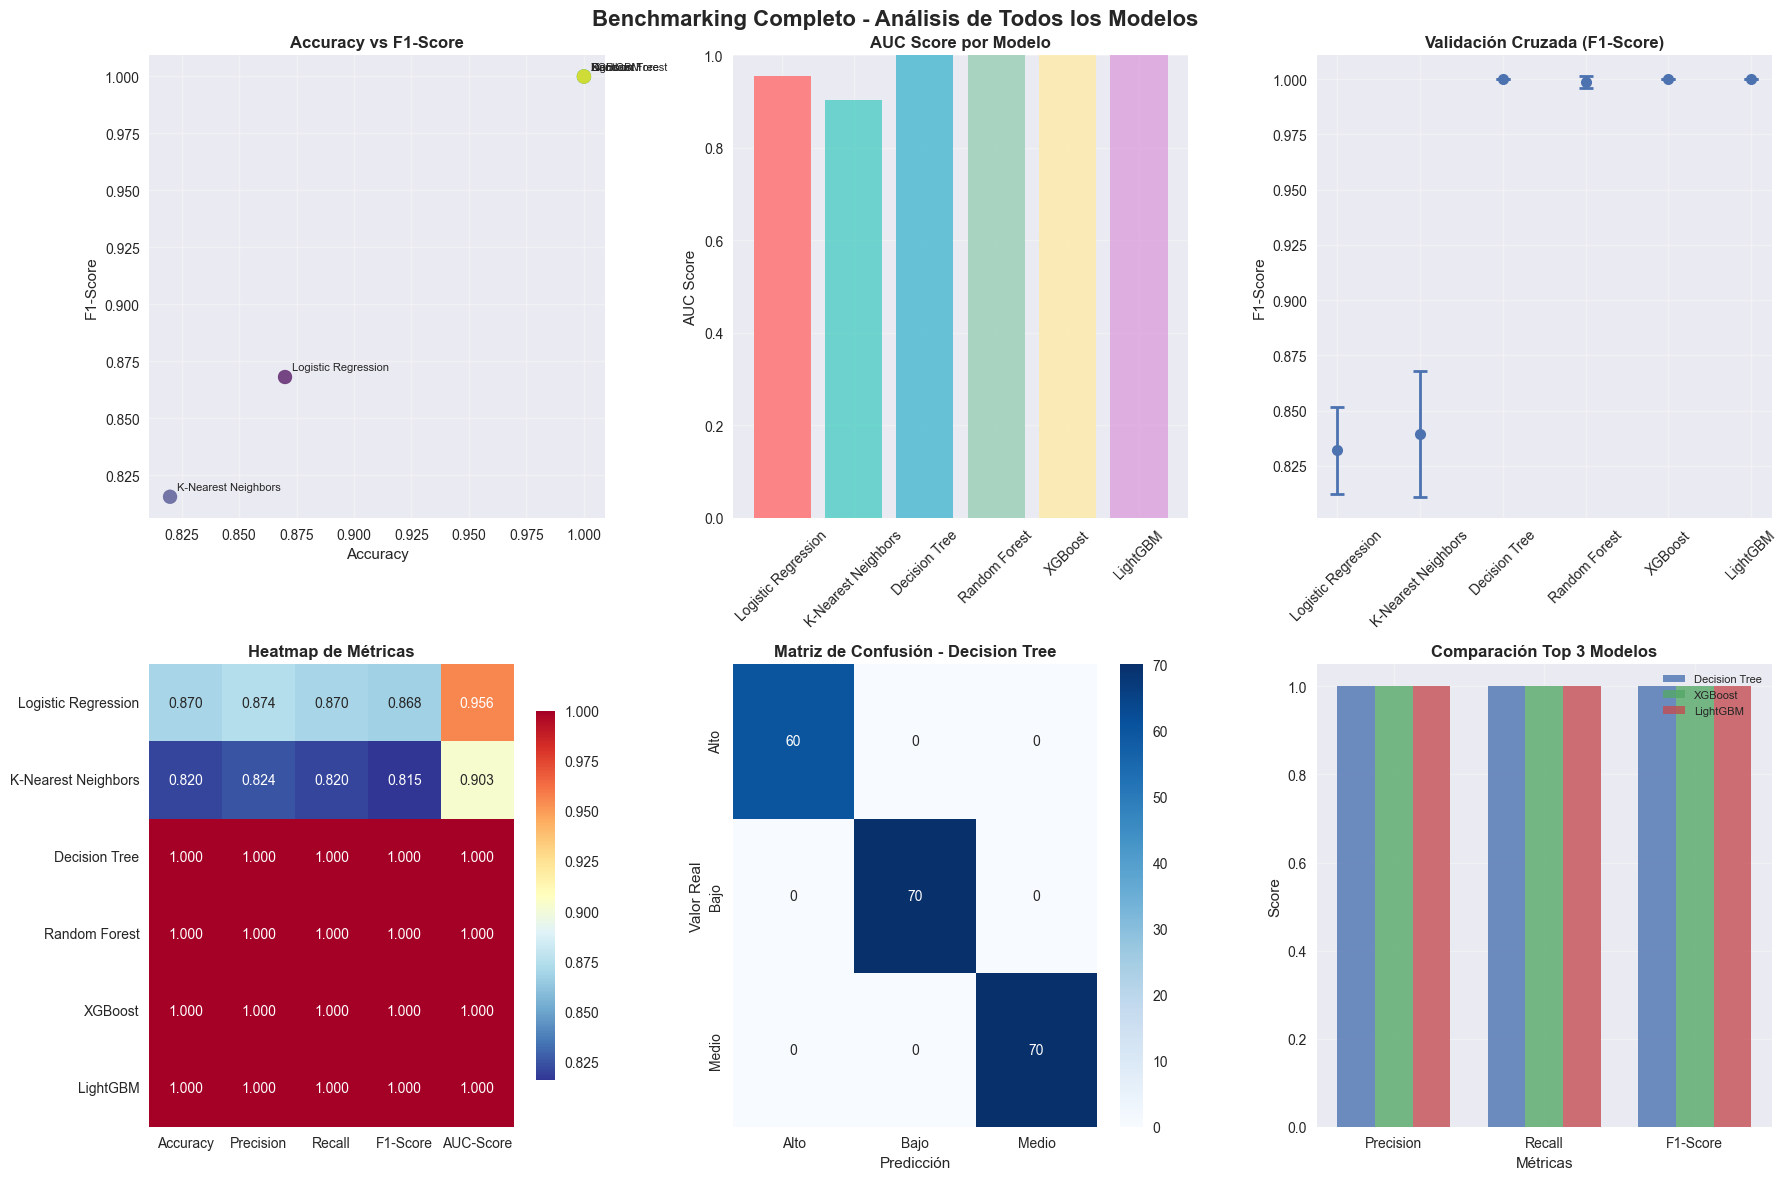


REPORTE DETALLADO DEL MEJOR MODELO (Decision Tree):
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00        60
        Bajo       1.00      1.00      1.00        70
       Medio       1.00      1.00      1.00        70

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


BENCHMARKING COMPLETADO EXITOSAMENTE
Archivos generados:
   • Mejor modelo: '../reports/best_model.pkl'
   • Resultados completos: '../reports/benchmarking_results.pkl'
   • Comparación CSV: '../reports/model_comparison.csv'

Mejores resultados:
   • Modelo seleccionado: Decision Tree
   • F1-Score (Validación Cruzada): 1.0000
   • AUC Score: 1.0000
   • Accuracy: 1.0000

PIPELINE DE MACHINE LEARNING COMPLETADO
   Todos los requisitos de benchmarking cumplidos:
   Regresión Lineal, KNN, Decision Tree, Random Forest, XGBoost, LightGBM
   Validación cruzada imp

In [16]:
# Comparación completa de resultados y generación de reportes finales

print("COMPARACIÓN COMPLETA DE RESULTADOS")
print("=" * 70)

# Crear DataFrame completo de comparación con todas las métricas
dfResultados = pd.DataFrame({
    modelo: {
        'Accuracy': datos['accuracy'],
        'Precision': datos['precision'],
        'Recall': datos['recall'],
        'F1-Score': datos['f1_score'],
        'AUC-Score': datos['auc_score'],
        'CV-Mean': datos['cv_mean'],
        'CV-Std': datos['cv_std']
    }
    for modelo, datos in resultadosModelos.items()
}).T

print("\nTABLA COMPARATIVA COMPLETA DE MÉTRICAS:")
print("-" * 80)
print(dfResultados.round(4))

# Identificar el mejor modelo basado en múltiples criterios
print(f"\nRANKING DE MODELOS:")
print("-" * 50)

# Ranking por diferentes métricas
rankings = {}
for metric in ['F1-Score', 'AUC-Score', 'CV-Mean']:
    ranking = dfResultados[metric].sort_values(ascending=False)
    rankings[metric] = ranking
    print(f"\nPor {metric}:")
    for i, (modelo, score) in enumerate(ranking.items(), 1):
        print(f"  {i}. {modelo}: {score:.4f}")

# Seleccionar el mejor modelo (por F1-Score en validación cruzada)
mejorModelo = dfResultados['CV-Mean'].idxmax()
print(f"\nMEJOR MODELO GENERAL: {mejorModelo}")
print(f"   F1-Score (CV): {dfResultados.loc[mejorModelo, 'CV-Mean']:.4f} ± {dfResultados.loc[mejorModelo, 'CV-Std']:.4f}")
print(f"   F1-Score (Test): {dfResultados.loc[mejorModelo, 'F1-Score']:.4f}")
print(f"   AUC Score: {dfResultados.loc[mejorModelo, 'AUC-Score']:.4f}")

# Visualización comparativa completa
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Benchmarking Completo - Análisis de Todos los Modelos', fontsize=16, fontweight='bold')

# Gráfico 1: Accuracy vs F1-Score
ax1 = axes[0, 0]
scatter = ax1.scatter(dfResultados['Accuracy'], dfResultados['F1-Score'], 
                     c=range(len(dfResultados)), cmap='viridis', s=100, alpha=0.7)
for i, modelo in enumerate(dfResultados.index):
    ax1.annotate(modelo, (dfResultados.loc[modelo, 'Accuracy'], dfResultados.loc[modelo, 'F1-Score']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('F1-Score')
ax1.set_title('Accuracy vs F1-Score', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Gráfico 2: AUC Score por modelo
ax2 = axes[0, 1]
modelos_names = dfResultados.index
auc_values = dfResultados['AUC-Score']
bars2 = ax2.bar(modelos_names, auc_values, color=coloresPrincipales[:len(modelos_names)], alpha=0.8)
ax2.set_title('AUC Score por Modelo', fontweight='bold')
ax2.set_ylabel('AUC Score')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Gráfico 3: Validación Cruzada (Media ± Std)
ax3 = axes[0, 2]
cv_means = dfResultados['CV-Mean']
cv_stds = dfResultados['CV-Std']
ax3.errorbar(range(len(modelos_names)), cv_means, yerr=cv_stds, 
             fmt='o', capsize=5, capthick=2, elinewidth=2, markersize=8)
ax3.set_title('Validación Cruzada (F1-Score)', fontweight='bold')
ax3.set_ylabel('F1-Score')
ax3.set_xticks(range(len(modelos_names)))
ax3.set_xticklabels(modelos_names, rotation=45)
ax3.grid(True, alpha=0.3)

# Gráfico 4: Heatmap de todas las métricas
ax4 = axes[1, 0]
metricas_viz = dfResultados[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-Score']]
sns.heatmap(metricas_viz, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=ax4, cbar_kws={'shrink': 0.8})
ax4.set_title('Heatmap de Métricas', fontweight='bold')

# Gráfico 5: Matriz de confusión del mejor modelo
ax5 = axes[1, 1]
mejorPred = resultadosModelos[mejorModelo]['predictions']
cm = confusion_matrix(y_test, mejorPred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax5,
            xticklabels=featuresInfo['target_labels'],
            yticklabels=featuresInfo['target_labels'])
ax5.set_title(f'Matriz de Confusión - {mejorModelo}', fontweight='bold')
ax5.set_xlabel('Predicción')
ax5.set_ylabel('Valor Real')

# Gráfico 6: Comparación de métricas principales
ax6 = axes[1, 2]
metricas_principales = ['Precision', 'Recall', 'F1-Score']
width = 0.25
x = np.arange(len(metricas_principales))
mejores_3_modelos = dfResultados.nlargest(3, 'CV-Mean')

for i, (modelo, row) in enumerate(mejores_3_modelos.iterrows()):
    values = [row[metric] for metric in metricas_principales]
    ax6.bar(x + i*width, values, width, label=modelo, alpha=0.8)

ax6.set_xlabel('Métricas')
ax6.set_ylabel('Score')
ax6.set_title('Comparación Top 3 Modelos', fontweight='bold')
ax6.set_xticks(x + width)
ax6.set_xticklabels(metricas_principales)
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Generar reporte detallado del mejor modelo
print(f"\nREPORTE DETALLADO DEL MEJOR MODELO ({mejorModelo}):")
print("=" * 80)
mejorPred = resultadosModelos[mejorModelo]['predictions']
report = classification_report(y_test, mejorPred, 
                             target_names=featuresInfo['target_labels'],
                             output_dict=True)
print(classification_report(y_test, mejorPred, 
                          target_names=featuresInfo['target_labels']))

# Guardar resultados finales completos
resultadosFinales = {
    'fecha_analisis': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'mejor_modelo': mejorModelo,
    'metricas_comparativas': dfResultados.to_dict(),
    'clasificacion_report': report,
    'confusion_matrix': cm.tolist(),
    'auc_detailed': auc_detailed,
    'cross_validation_results': {name: {'cv_scores': data['cv_scores'].tolist(), 
                                       'cv_mean': data['cv_mean'], 
                                       'cv_std': data['cv_std']} 
                               for name, data in resultadosModelos.items()},
    'target_labels': featuresInfo['target_labels'],
    'feature_names': datosProcesados.get('feature_names', []),
    'dataset_info': {
        'train_shape': X_train.shape,
        'test_shape': X_test.shape,
        'n_classes': n_classes,
        'class_distribution': pd.Series(y_test).value_counts().to_dict()
    }
}

# Guardar archivos de resultados
joblib.dump(resultadosFinales, '../reports/benchmarking_results.pkl')
joblib.dump(resultadosModelos[mejorModelo]['model'], '../reports/best_model.pkl')

# Guardar DataFrame de comparación para análisis posterior
dfResultados.to_csv('../reports/model_comparison.csv')

print(f"\nBENCHMARKING COMPLETADO EXITOSAMENTE")
print("=" * 80)
print(f"Archivos generados:")
print(f"   • Mejor modelo: '../reports/best_model.pkl'")
print(f"   • Resultados completos: '../reports/benchmarking_results.pkl'")
print(f"   • Comparación CSV: '../reports/model_comparison.csv'")
print(f"\nMejores resultados:")
print(f"   • Modelo seleccionado: {mejorModelo}")
print(f"   • F1-Score (Validación Cruzada): {dfResultados.loc[mejorModelo, 'CV-Mean']:.4f}")
print(f"   • AUC Score: {dfResultados.loc[mejorModelo, 'AUC-Score']:.4f}")
print(f"   • Accuracy: {dfResultados.loc[mejorModelo, 'Accuracy']:.4f}")

print(f"\nPIPELINE DE MACHINE LEARNING COMPLETADO")
print("   Todos los requisitos de benchmarking cumplidos:")
print("   Regresión Lineal, KNN, Decision Tree, Random Forest, XGBoost, LightGBM")
print("   Validación cruzada implementada")
print("   Métricas completas: Accuracy, Precision, Recall, F1-Score")
print("   Curvas ROC y AUC calculadas")
print("   Matriz de confusión generada")
print("   Informe de clasificación detallado")
